<a href="https://colab.research.google.com/github/MauricioVazquezM/Skin_Cancer_Detection_Project/blob/memo/NOTEBOOKS%26CODE/ModeloXGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prueba de modelo XG Boost para metadatos

## Content

- Libraries
- Data preparation
- Model structure
- Tests

In [2]:
# Librerías
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from skimage.feature import hog
from skimage import io, exposure, img_as_float

### Data preparation

#### Metadata

In [3]:
df = pd.read_csv('df_datos.csv')
df.head(5)

,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,...,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence,height,width,channel
0,ISIC_9758092,0,IP_3026867,65.0,male,anterior torso,3.29,TBP tile: close-up,3D: white,17.562934,...,NaN,NaN,NaN,NaN,NaN,NaN,99.988377,127.0,127.0,3.0
1,ISIC_1681724,0,IP_5824484,60.0,female,head/neck,2.90,TBP tile: close-up,3D: XP,21.770520,...,NaN,NaN,NaN,NaN,NaN,NaN,99.999860,127.0,127.0,3.0
2,ISIC_1712597,0,IP_1999627,80.0,male,lower extremity,4.53,TBP tile: close-up,3D: white,20.704181,...,NaN,NaN,NaN,NaN,NaN,NaN,99.931681,127.0,127.0,3.0
3,ISIC_7413483,0,IP_8172184,75.0,male,anterior torso,2.74,TBP tile: close-up,3D: white,16.633670,...,NaN,NaN,NaN,NaN,NaN,NaN,99.963610,127.0,127.0,3.0
4,ISIC_5320191,0,IP_7167379,60.0,male,upper extremity,4.53,TBP tile: close-up,3D: XP,26.025550,...,NaN,NaN,NaN,NaN,NaN,NaN,99.392580,127.0,127.0,3.0


In [4]:
# Seguimos los pasos realizados durante el EDA - eliminación de variables

# Ahora eliminaremos las columnas del dataframe que deban ser eliminadas con base
  # en el análisis anterios (explican lo mismo), así como las variables que
  # sabemos que no aportan nada o no nos servirán de nada
df.drop(['tbp_lv_A',
'tbp_lv_Aext',
'tbp_lv_B',
'tbp_lv_Bext',
'tbp_lv_C',
'tbp_lv_Cext',
'tbp_lv_H',
'tbp_lv_Hext',
'tbp_lv_L',
'tbp_lv_Lext',
'tbp_lv_area_perim_ratio',
'tbp_lv_color_std_mean',
'tbp_lv_deltaA',
'tbp_lv_deltaB',
'tbp_lv_deltaL',
'tbp_lv_deltaLB',
'tbp_lv_eccentricity',
'tbp_lv_minorAxisMM',
'tbp_lv_perimeterMM',
'tbp_lv_radial_color_std_max',
'tbp_lv_stdL',
'tbp_lv_stdLExt',
'tbp_lv_symm_2axis',
'tbp_lv_symm_2axis_angle',
'tbp_lv_x',
'tbp_lv_y',
'tbp_lv_z',
'patient_id',
'image_type',
'tbp_tile_type',
'anatom_site_general',
'tbp_lv_location',
'attribution',
'copyright_license',
'iddx_full',
'iddx_2',
'iddx_3',
'iddx_4',
'iddx_5',
'height',
'width',
'channel',
'tbp_lv_nevi_confidence',
'tbp_lv_dnn_lesion_confidence'], axis=1, inplace=True)

# Dropearemos las variables que en su mayoría están llenas de null
df.drop(['mel_mitotic_index', 'lesion_id', 'mel_thick_mm'], axis=1, inplace=True)

# Quitamos ahora las columnas con datos faltantes
df.dropna(subset=['age_approx', 'sex'], inplace=True)

# Codificación binaria de sexo
df["sex"] = df["sex"].astype('category').cat.codes

# Set index a imagen id
df.set_index(df.columns[0], inplace=True)

# Drop explicación de columna target
df.drop(['iddx_1'], axis=1, inplace=True)

# Get dummies for categorial variable: "location simple"
df = pd.concat([df, pd.get_dummies(df['tbp_lv_location_simple'], dtype=int)], axis=1)
df.drop(['tbp_lv_location_simple'], axis=1, inplace=True)

In [5]:
df['target'].value_counts()

,count
target,
0,9607
1,381


In [6]:
df.head(5)

,isic_id,target,age_approx,sex,clin_size_long_diam_mm,tbp_lv_areaMM2,tbp_lv_deltaLBnorm,tbp_lv_location_simple,tbp_lv_norm_border,tbp_lv_norm_color,iddx_1
0,ISIC_9758092,0,65.0,male,3.29,4.428598,6.438281,Torso Front,3.982105,3.522489,Benign
1,ISIC_1681724,0,60.0,female,2.90,5.423156,5.795393,Head & Neck,1.817077,2.071954,Benign
2,ISIC_1712597,0,80.0,male,4.53,7.543629,4.538036,Left Leg,4.414372,2.086883,Benign
3,ISIC_7413483,0,75.0,male,2.74,5.104147,7.814732,Torso Front,3.045189,3.112155,Benign
4,ISIC_5320191,0,60.0,male,4.53,9.213736,5.518769,Right Arm,4.887216,4.477429,Benign


#### Image data

Transform image data into a vector.

In [ ]:
# Configuration: Images Directory
image_dir = "cancer_cropped"  # folder with all the images
all_image_paths = [os.path.join(image_dir, fname) for fname in os.listdir(image_dir) if fname.endswith('.jpg')]

# Function for loading and processing images
def load_images(paths):
    images = []
    for path in paths:
        img = io.imread(path) # HERE CHANGE THE FORMAT TO GRAYSCALE
        img = img_as_float(img)  # Convert to float in range [0, 1]
        images.append(img)
    return images

images = load_images(all_image_paths)

hog_dataset = []
# Processing and visualization example
for img in images:
  fd = hog(
      orientations = 8, # EDA fueron 9
      pixels_per_cell=(8, 8),
      cells_per_block=(2, 2),
      block_norm='L2-Hys',
      visualize=False,
      channel_axis=-1,
      feature_vector=True,
      image=img
  )
  hog_dataset.append(fd)
print(fd.shape)
hog_df = pd.DataFrame(hog_dataset)

##### Ejemplo hog

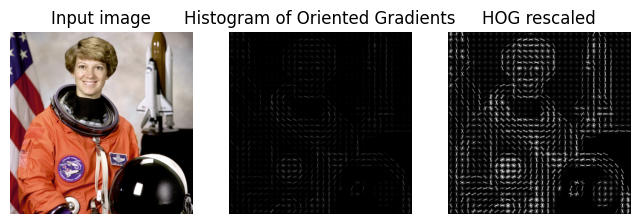

In [4]:
import matplotlib.pyplot as plt

from skimage.feature import hog
from skimage import data, exposure


image = data.astronaut()

fd, hog_image = hog(
    image,
    orientations=8,
    pixels_per_cell=(16, 16),
    cells_per_block=(1, 1),
    visualize=True,
    channel_axis=-1
)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(8, 6), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(image, cmap=plt.cm.gray)
ax1.set_title('Input image')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

ax2.axis('off')
ax2.imshow(hog_image, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
ax3.axis('off')
ax3.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax3.set_title('HOG rescaled')
plt.show()

In [12]:
fd, fd.shape

(array([0.39692362, 0.39692362, 0.19722037, ..., 0.26781881, 0.19759087,
        0.50605803]),
 (8192,))

#### Data concat

In [ ]:
full_data = pd.concat([df, hog_df], axis=1)

In [7]:
X = full_data.drop('target', axis=1)
y = full_data['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Model Structure

In [ ]:
# Model Training
# Define model parameters
model = xgb.XGBClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=5,
        random_state=42
)

# Fit the model
model.fit(X_train, y_train)

### Model Evaluation

In [ ]:
# Model Evaluation
# Make predictions
y_pred = model.predict(X_test)

# Compute evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

### Feature Importance

In [ ]:
# 4. Feature Importance
def get_feature_importance(model):
    """
    Extract and visualize feature importance

    Parameters:
    model (XGBoost model): Trained model

    Returns:
    Pandas DataFrame of feature importances
    """
    feature_importance = model.feature_importances_
    feature_names = model.feature_names_in_

    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': feature_importance
    }).sort_values('importance', ascending=False)

    return importance_df

# Extract and visualize feature importance
importance_df = get_feature_importance(model)
importance_df